# exp2 逻辑回归
在本次练习中，我们将要实现逻辑回归并应用到一个分类任务。我们还将通过将正则化加入训练算法，来提高算法的鲁棒性，并用更复杂的情形来测试它。

# 1 逻辑回归
构建一个模型 (x1, x2) -> y， 预测某个学生是否被录取。

In [536]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt 
import torch 

## 1.1 数据可视化

In [537]:
path = "./Andrew-NG-Meachine-Learning/machine-learning-ex2/ex2/ex2data1.txt"
data = pd.read_csv(path, header=None, names=['exam1', 'exam2', 'Admitted'])
data.head(), data.describe()

(       exam1      exam2  Admitted
 0  34.623660  78.024693         0
 1  30.286711  43.894998         0
 2  35.847409  72.902198         0
 3  60.182599  86.308552         1
 4  79.032736  75.344376         1,
             exam1       exam2    Admitted
 count  100.000000  100.000000  100.000000
 mean    65.644274   66.221998    0.600000
 std     19.458222   18.582783    0.492366
 min     30.058822   30.603263    0.000000
 25%     50.919511   48.179205    0.000000
 50%     67.032988   67.682381    1.000000
 75%     80.212529   79.360605    1.000000
 max     99.827858   98.869436    1.000000)

现在我们来进行作图啦～，肯定要是创建两个分数的散点图，并使用颜色编码来可视化，如果样本是正的或者负的。

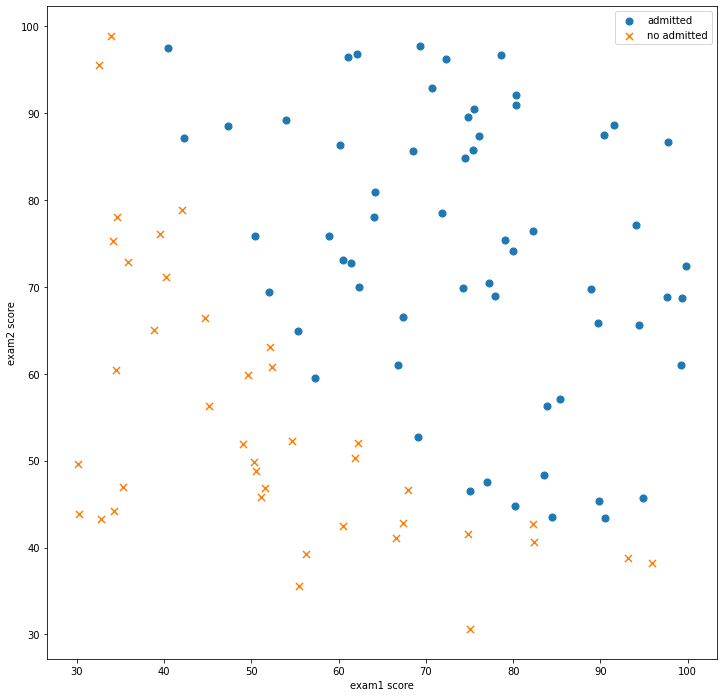

,exam1,exam2,Admitted
count,60.000000,60.000000,60.0
mean,74.718923,73.956402,1.0
std,14.912420,16.012403,0.0
min,40.457551,43.390602,1.0
25%,63.597244,65.409676,1.0
50%,75.436657,74.753748,1.0
75%,84.675745,87.442625,1.0
max,99.827858,97.718692,1.0


In [538]:
positive = data[data['Admitted'] == 1]
negative = data[data['Admitted'] == 0]
fig, ax = plt.subplots(figsize=(12, 12))
ax.scatter(x=positive['exam1'], y=positive['exam2'],s=50, marker='o',label='admitted')
ax.scatter(x=negative['exam1'], y=negative['exam2'],s=50, marker='x',label='no admitted')
ax.legend()
ax.set_xlabel('exam1 score')
ax.set_ylabel('exam2 score')
plt.show()
positive.describe()

## 1.2 实现
### 1.2.1 sigmoid 函数
逻辑回归函数为：
$$
    h_\theta = g(\theta^Tx)
$$
g 代表一个常用的逻辑函数为S形函数，公式为：
$$
    g(z) = \frac{1}{1 + e^{-z}}
$$
合起来，我们可以得到回归模型的假设函数： 
$$
    h_\theta(x) = \frac{1}{1 + e^{-\theta^Tx}}
$$

In [539]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

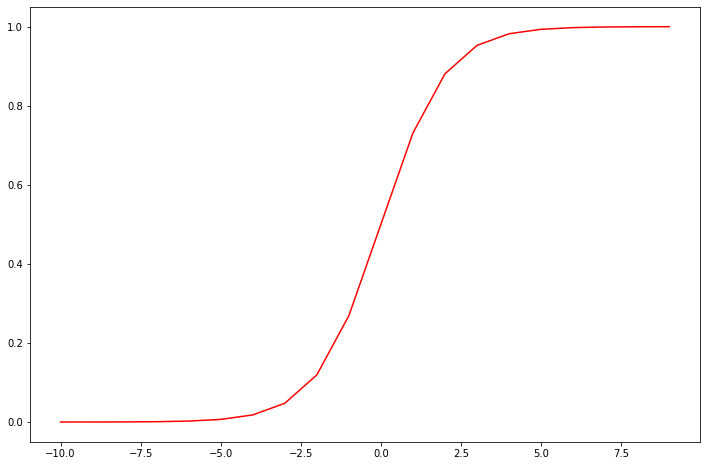

In [540]:
# 做一个快速的检查，确保这个函数可以工作
nums = np.arange(-10, 10, step = 1)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(nums, sigmoid(nums), 'r')


# 1.2.2 代价函数和梯度
代价函数：
$$
        J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}log\left(h_\theta(x^{(i)})\right) - 
        \left(1 - y^{(i)}\right)log\left(1 - h_\theta(x^{(i)}\right)  \right]
$$


虽然这个梯度函数和前面线性回归的梯度很像，但是要记住$h_\theta(x)$ 是不一样的

In [541]:
def cost(theta, X, y):
    """ 
    损失函数实现
    X: shape(m, n)
    y: shape(m, 1)
    theta: (n, 1)
    """
    theta = theta.reshape(3,1)
    h = sigmoid(np.dot(X, theta)) # hypothesis
    loss = -(np.multiply(y, np.log(h)) + np.multiply(1 - y, np.log(1 - h)))# loss
    return np.sum(loss)/len(X) 

**处理数据**

In [542]:
data.insert(0, 'Ones', 1) 
# 初始化X, y, theta
cols = data.shape[1]
X = data.iloc[:,0:cols - 1]
y = data.iloc[:,cols - 1: cols]
X.head(), y.head()

(   Ones      exam1      exam2
 0     1  34.623660  78.024693
 1     1  30.286711  43.894998
 2     1  35.847409  72.902198
 3     1  60.182599  86.308552
 4     1  79.032736  75.344376,
    Admitted
 0         0
 1         0
 2         0
 3         1
 4         1)

In [543]:
# 转化X, y 初始化theta
X = np.array(X)
y = np.array(y)
theta = np.zeros(3)
X.shape, theta, y.shape

((100, 3), array([0., 0., 0.]), (100, 1))

In [544]:
# 使用初始值计算cost
cost(theta, X, y)

0.6931471805599453

# 梯度：
$$
        \frac{\partial J(\theta)}{ \partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left(  
                h_\theta(x^{(i)} - y^{(i)})x_j^{(i)}
        \right)
$$

In [545]:
theta.shape

(3,)

In [546]:
def gradient(theta, X, y):
    """ 
    损失下降函数, 这里不进行参数更新哦
    X: (m, n)
    y: (m, 1)
    theta: (n, )
    """    
    theta = theta.reshape(3,1)
    res = (np.dot(X.T, sigmoid(np.dot(X, theta)) - y) / len(X))
    return res.flatten('F')
gradient(theta, X, y)

array([ -0.1       , -12.00921659, -11.26284221])

# 1.2.3 拟合参数
这里采用的是scipy.opti.minimize去寻找参数


In [547]:
import scipy.optimize as opt 
res = opt.minimize(fun=cost, x0=theta, args=(X, y), method="Newton-CG", jac=gradient)
# result = opt.fmin_tnc(func=cost, x0=theta, fprime=gradient, args=(X, y))
# result
res


     fun: 0.20349772797212348
     jac: array([-8.36516345e-06, -8.07377274e-04, -7.25332114e-04])
 message: 'Optimization terminated successfully.'
    nfev: 71
    nhev: 0
     nit: 28
    njev: 181
  status: 0
 success: True
       x: array([-25.14802137,   0.20612452,   0.20136463])

In [548]:
cost(result[0], X, y)

0.20349770158947472

$$
    \theta_0 + \theta_1 x + \theta_2 y = 0
$$
可以推导
$$
    y = -\frac{\theta_0 + \theta_1x}{\theta_2}
$$
该曲线为分割曲线

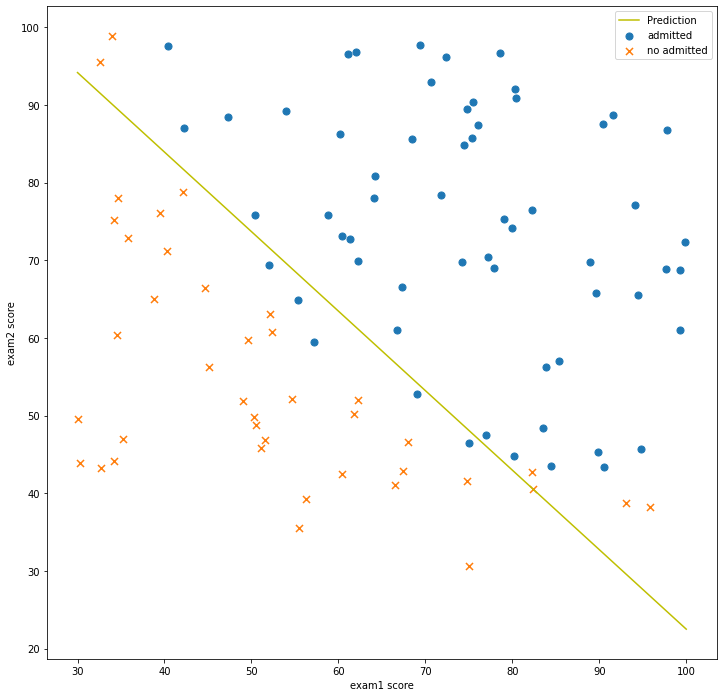

In [549]:
# 画出决策曲线
plotting_x1 = np.linspace(30, 100, 100)
thetas_1 = result[0] 
plotting_y1 = -(thetas_1[0] + thetas_1[1] * plotting_x1) / thetas_1[2]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(plotting_x1, plotting_y1, 'y', label = 'Prediction')
ax.scatter(x=positive['exam1'], y=positive['exam2'],s=50, marker='o',label='admitted')
ax.scatter(x=negative['exam1'], y=negative['exam2'],s=50, marker='x',label='no admitted')
ax.legend()
ax.set_xlabel('exam1 score')
ax.set_ylabel('exam2 score')
plt.show()

# 1.2.4 评价逻辑回归模型
在确定参数之后，我们可以使用跟这个模型来预测学生是否录取。如果一个学生exam1 得分45分，exam2得分85份，那么求他录取的概率？

0.776

In [550]:
def hfun1(theta, x):
    return sigmoid(np.dot(theta.T, x))
hfun1(result[0], [1, 45, 85])

0.7762906228757674

另外一种评价$\theta$的方法是看模型在训练及伤的正确率怎么样。

写一个predict的函数，给出数据以及参数后，会返回“1”或者“0”。 

然后再把这个predict函数用于训练集上，看看准确略怎么样。

In [551]:
# 定义预测函数
def predict(theta, X):
    """
    X: matrix(m, n)
    theta: matrix(1, n)
    """
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [552]:
# 统计预测正确率
theta_min = np.matrix(result[0])
preditions = predict(theta_min, X)
correct = [1 if a ^ b == 0 else 0 for (a, b) in zip(preditions, y)]
accuracy = (sum(map(int, correct)) % len(correct))
print("accuracy: {}%".format(accuracy))


accuracy: 89%


# 2 正则化逻辑回归
在训练的第二部分，我们将实现加入正则化提升逻辑回归算法。

设想你是工厂的生产主管，你有一些芯片在两次测试中的测试结果，测试结果决定是否芯片要接受或者抛弃。你有一些历史数据，帮助你构建一个逻辑回归逻辑。

# 2.1 数据可视化

In [553]:
path2 = '../吴恩达-机器学习/Andrew-NG-Meachine-Learning/machine-learning-ex2/ex2/ex2data2.txt'
data_init = pd.read_csv(path2, header=None, names=['test1', 'test2', 'accepted'])
data_init.head()

,test1,test2,accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


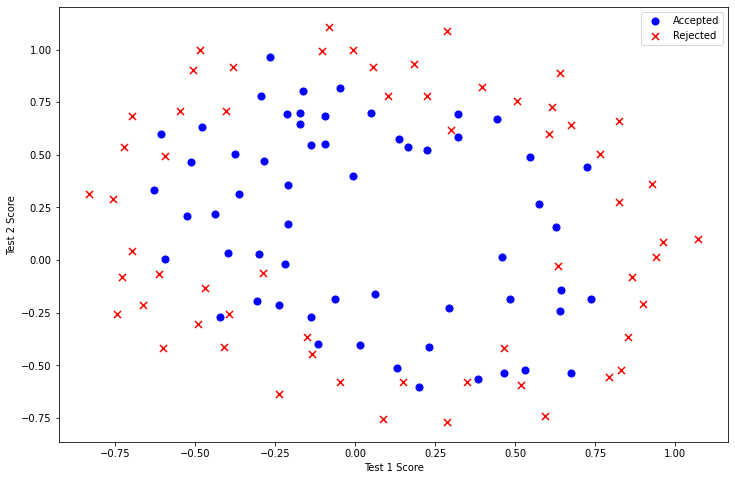

In [554]:
positive2 = data_init[data_init['accepted'].isin([1])]
negative2 = data_init[data_init['accepted'].isin([0])]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['test1'], positive2['test2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['test1'], negative2['test2'], s=50, c='r', marker='x', label='Rejected')
ax.legend()
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')
plt.show()

以上图片显示，这个数据集不能像之前一样使用直线将两部分分割。而逻辑回归只适用于线性分割，所以，这个数据集不能直接使用逻辑回归

## 2.2 特征映射
一种更好的使用数据集的方式是为每组数据创造更多的特征，这里我们为x1,x2创建最高到6次幂的特征。

In [555]:
degree = 6 
data2 = data_init

x1 = data2['test1']
x2 = data2['test2']
data2.insert(3, 'Ones', 1)
for i in range(1, degree + 1):
    for j in range(0, i + 1):
        data2['F' + str(i -j) + str(j)] = np.power(x1, i - j) * np.power(x2, j)
data2.drop('test1', axis = 1, inplace = True)
data2.drop('test2', axis = 1, inplace = True)
data2.head()

,accepted,Ones,F10,F01,F20,F11,F02,F30,F21,F12,...,F23,F14,F05,F60,F51,F42,F33,F24,F15,F06
0,1,1,0.051267,0.69956,0.002628,0.035864,0.489384,0.000135,0.001839,0.025089,...,0.000900,0.012278,0.167542,1.815630e-08,2.477505e-07,0.000003,0.000046,0.000629,0.008589,0.117206
1,1,1,-0.092742,0.68494,0.008601,-0.063523,0.469143,-0.000798,0.005891,-0.043509,...,0.002764,-0.020412,0.150752,6.362953e-07,-4.699318e-06,0.000035,-0.000256,0.001893,-0.013981,0.103256
2,1,1,-0.213710,0.69225,0.045672,-0.147941,0.479210,-0.009761,0.031616,-0.102412,...,0.015151,-0.049077,0.158970,9.526844e-05,-3.085938e-04,0.001000,-0.003238,0.010488,-0.033973,0.110047
3,1,1,-0.375000,0.50219,0.140625,-0.188321,0.252195,-0.052734,0.070620,-0.094573,...,0.017810,-0.023851,0.031940,2.780914e-03,-3.724126e-03,0.004987,-0.006679,0.008944,-0.011978,0.016040
4,1,1,-0.513250,0.46564,0.263426,-0.238990,0.216821,-0.135203,0.122661,-0.111283,...,0.026596,-0.024128,0.021890,1.827990e-02,-1.658422e-02,0.015046,-0.013650,0.012384,-0.011235,0.010193


# 2.3 代价函数和梯度

# 2.3.1 实现代价函数
$$
        J(\theta) = \frac{1}{m} \sum_{i = 1}^{m} \left[-y^{(i)}log\left(h_\theta(x^{(i)})\right) - 
        \left(1 - y^{(i)}\right)log\left(1 - h_\theta(x^{(i)}\right)  \right] + 
        \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_j^2
$$

In [556]:

def costReg(theta, X, y, lamda):
    """
    theta: shape(n, )
    X: shape(m, n)
    y: shape(m, 1)
    lamda: 正则化参数
    """
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)

    m = len(X)

    h = sigmoid(X * theta.T)
    A = np.multiply(-y, np.log(h)) + np.multiply(-(1 - y), np.log(1 - h))

    A = np.sum(A) / m

    B = (theta * theta.T)
    B = lamda * B / (2 * m)

    return A + B 


In [557]:
## 初始化X, y, tehta
cols = data2.shape[1]
X2 = data2.iloc[:, 1:cols]
y2 = data2.iloc[:,0:1]
theta2 = np.zeros(cols - 1)

## 类型转换
X2 = np.array(X2) 
y2 = np.array(y2) 

## 设置lamda 为1
lamda = 1
X2.shape, y2.shape, theta2.shape

((118, 28), (118, 1), (28,))

In [558]:

# 计算初始的代价函数
costReg(theta2, X2, y2, lamda) 


matrix([[0.69314718]])

# 2.3.2 实现正则化的梯度函数
$$
        \frac{\partial J(\theta)}{ \partial \theta_j} = \frac{1}{m} \sum_{i=1}^{m} \left(  
                (h_\theta(x^{(i)}) - y^{(i)})x_j^{(i)}
        \right) + \frac{\lambda}{m}\theta_j , j \ge 1
$$

In [605]:
def graidentReg(theta, X, y, lamda): 
    """ 
    X: (m, n) 
    y: (m, 1)
    theta: (n, )
    lamda: float
    """
    X = np.matrix(X)
    y = np.matrix(y)
    _theta = theta
    theta = np.matrix(theta)
    A = (X.T * (sigmoid(X * theta.T) - y) / len(X)).T
    B1toN = lamda * _theta[1:] / len(X) 
    B0 = np.array([0])
    B = np.append(B0, B1toN).reshape(1, -1)
    return (A + B)

In [611]:
a = np.random.rand(3,4)
len(a), len(a[0])

(3, 4)

In [629]:
# gradient
def gradient(theta, X, y, lambd):
    """
    X: array (m, n) 
    y: array (m, 1)
    theta: (n,)
    lambd: float
    """
    _theta = theta.reshape(-1, 1)
    left = X.T.dot(sigmoid(X.dot(_theta)) - y) / len(X)
    print("left", left.shape)
    left = left.T[0]

    right0 = np.array([0])
    right1 = lambd * theta[1:] / len(X)
    right = np.append(right0, right1)
    assert(left.shape == right.shape)
    return left + right
gradient(theta2, X2, y2,  lamda)

left (28, 1)


array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

In [606]:
graidentReg(theta2, X2, y2, lamda).A[0]

array([8.47457627e-03, 1.87880932e-02, 7.77711864e-05, 5.03446395e-02,
       1.15013308e-02, 3.76648474e-02, 1.83559872e-02, 7.32393391e-03,
       8.19244468e-03, 2.34764889e-02, 3.93486234e-02, 2.23923907e-03,
       1.28600503e-02, 3.09593720e-03, 3.93028171e-02, 1.99707467e-02,
       4.32983232e-03, 3.38643902e-03, 5.83822078e-03, 4.47629067e-03,
       3.10079849e-02, 3.10312442e-02, 1.09740238e-03, 6.31570797e-03,
       4.08503006e-04, 7.26504316e-03, 1.37646175e-03, 3.87936363e-02])

In [561]:
result2 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=graidentReg, args=(X2, y2, lamda))
result2
# res = opt.minimize(fun=costReg, x0=theta2, args=(X2, y2,lamda), method='Newton-CG', jac=graidentReg)
# res

  NIT   NF   F                       GTG
    0    1  6.931471805599454E-01   1.28006529E-02
    1    6  5.405031303941882E-01   9.47468997E-04
tnc: fscale = 32.4876
    2   11  5.357749524260595E-01   1.47915698E-05
tnc: |fn-fn-1] = 0 -> convergence
    3   54  5.357749524260595E-01   1.47915698E-05
tnc: Converged (|f_n-f_(n-1)| ~= 0)


(array([ 1.25441478,  0.62276761,  1.19242758, -2.00505521, -0.87290727,
        -1.36184295,  0.12573875, -0.35536853, -0.35603627, -0.17096329,
        -1.45784677, -0.06683323, -0.61498637, -0.25080286, -1.18096031,
        -0.22566838, -0.20562886, -0.06382329, -0.2718703 , -0.2765899 ,
        -0.4683602 , -1.03247356,  0.01627587, -0.29695277,  0.00581073,
        -0.32631636, -0.12073385, -0.93022981]),
 54,
 1)

In [562]:
theta_min = np.matrix(result2[0])
predictions = predict(theta_min, X2)
correct = [1 if ((a == 1 and b == 1) or (a == 0 and b == 0)) else 0 for (a, b) in zip(predictions, y2)]
accuracy = (sum(map(int, correct)) % len(correct))
print ('accuracy = {0}%'.format(accuracy))

accuracy = 98%


In [563]:
def hfunc2(theta, x1, x2):
    temp = theta[0][0]
    place = 0
    for i in range(1, degree+1):
        for j in range(0, i+1):
            temp+= np.power(x1, i-j) * np.power(x2, j) * theta[0][place+1]
            place+=1
    return temp

In [564]:
def find_decision_boundary(theta):
    t1 = np.linspace(-1, 1.5, 1000)
    t2 = np.linspace(-1, 1.5, 1000)

    cordinates = [(x, y) for x in t1 for y in t2] #[(), (), ..., ()] 1000000个
    x_cord, y_cord = zip(*cordinates) 
    h_val = pd.DataFrame({'x1':x_cord, 'x2':y_cord})
    h_val['hval'] = hfunc2(theta, h_val['x1'], h_val['x2'])

    decision = h_val[np.abs(h_val['hval']) < 2 * 10**-3]
    return decision.x1, decision.x2

         x1        x2
0      -1.0 -1.000000
1      -1.0 -0.997497
2      -1.0 -0.994995
3      -1.0 -0.992492
4      -1.0 -0.989990
...     ...       ...
999995  1.5  1.489990
999996  1.5  1.492492
999997  1.5  1.494995
999998  1.5  1.497497
999999  1.5  1.500000

[1000000 rows x 2 columns]


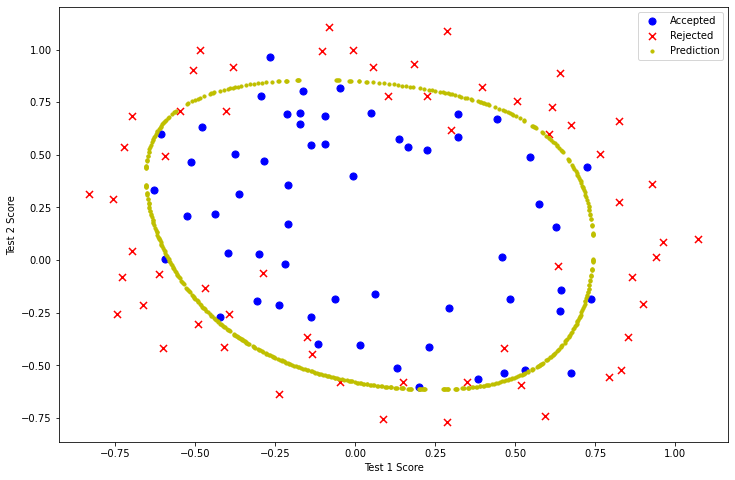

In [565]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['test1'], positive2['test2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['test1'], negative2['test2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')


x, y = find_decision_boundary(result2)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()

In [600]:
# lamda = 0
lamda = 0
result3 = opt.fmin_tnc(func=costReg, x0=theta2, fprime=graidentReg, args=(X2, y2, lamda))
result3

  NIT   NF   F                       GTG
    0    1  6.931471805599454E-01   1.28006529E-02
tnc: stepmx = 1000
    1    7  3.769318136601961E-01   2.82189287E-03
    2   11  3.576204961210157E-01   1.61503207E-04
tnc: fscale = 78.6882
    3   20  3.259498627862729E-01   6.21116597E-05
    4   23  3.213862516231925E-01   3.83963851E-05
    5   34  3.091059163337339E-01   5.29875617E-05
    6   48  2.997584010679736E-01   5.62393683E-05
    7   60  2.927660231525873E-01   3.30726811E-05
    8   64  2.920171159823885E-01   2.52129023E-06
    9   78  2.840056715418185E-01   1.40907129E-05
   10   81  2.835040818741775E-01   2.20154948E-06
   11   92  2.811988744399294E-01   1.40009922E-06
   12  107  2.781688987335570E-01   3.76645539E-06
   13  122  2.740490009804119E-01   2.11733746E-06
   14  130  2.730049583090320E-01   5.16560947E-07
   15  133  2.729275838354736E-01   1.07052370E-06
   16  148  2.719213742990224E-01   3.36472832E-07
tnc: fscale = 1723.95
   17  156  2.718089949988242

(array([  10.82993245,   15.52335932,    5.60124174, -104.11697129,
         -49.3418218 ,  -46.85618504, -122.44559351,  -83.50620745,
         -31.77724483,    2.54955312,  374.06275964,  293.08409041,
         414.98994293,  162.29678759,   70.9146443 ,  220.27114683,
         281.26817949,  293.92727488,  117.40112591,    2.59523077,
          -5.81376981, -458.32233238, -552.44431804, -791.67801444,
        -493.76055761, -512.41390534, -177.12482707,  -46.32822678]),
 280,
 3)

         x1        x2
0      -1.0 -1.000000
1      -1.0 -0.997497
2      -1.0 -0.994995
3      -1.0 -0.992492
4      -1.0 -0.989990
...     ...       ...
999995  1.5  1.489990
999996  1.5  1.492492
999997  1.5  1.494995
999998  1.5  1.497497
999999  1.5  1.500000

[1000000 rows x 2 columns]


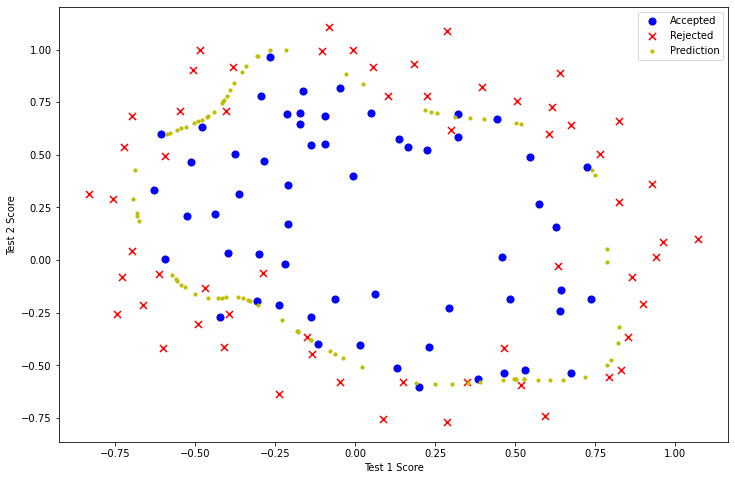

In [567]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(positive2['test1'], positive2['test2'], s=50, c='b', marker='o', label='Accepted')
ax.scatter(negative2['test1'], negative2['test2'], s=50, c='r', marker='x', label='Rejected')
ax.set_xlabel('Test 1 Score')
ax.set_ylabel('Test 2 Score')

x, y = find_decision_boundary(result3)
plt.scatter(x, y, c='y', s=10, label='Prediction')
ax.legend()
plt.show()